# KPI Metrics Visualization

Through this notebook, we want to provide a way for users to explore and visualize the available KPI metrics. Although we plan on setting up external tools (such as Apache Superset) for visualization, we also want to provide the option to visualize KPIs in a Jupyter notebook native environment since that is where a lot of data science development happens.

This notebook comprises of the three main sections:
1. Fetch and view available data from Ceph bucket
2. Create graphs for all the KPIs available for a selected dashboard and job
3. Create graphs for the KPIs at a Job level for a selected dashbaord
4. Create graphs for all the KPIs at a Test level for a selected dashboard and job

In [1]:
# Import required libraries
import os
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from collections import defaultdict
from dotenv import load_dotenv, find_dotenv

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from ipynb.fs.defs.metric_template import CephCommunication

load_dotenv(find_dotenv())
sns.set(rc={"figure.figsize": (15, 5)})

In [2]:
## Specify variables

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY")

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

## Helper functions for plotting

In [3]:
def plot_grids(tab, test, df, metric_name, x_label, y_label, graph_title):
    """
    Takes as an argument the dashboard tab, test name, metric df, the KPI metric, metric unit and
    the graph title

    Plots the distribution of KPI values over time for the different jobs(grids)
    in a given TestGrid dashboard tab
    """
    for grid in df[df["tab"] == tab]["grid"].unique():
        grid_values = pd.DataFrame()
        grid_values = df[
            (df["tab"] == tab) & (df["grid"] == grid) & (df["test"] == test)
        ]
        sns.lineplot(
            x="timestamp",
            y=metric_name,
            data=grid_values,
            legend="brief",
            label=str(grid),
        )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(graph_title)
    plt.show()

In [4]:
def plot_metrics_tab_grid(tab, grid, df, metric_name, x_label, y_label, graph_title):
    """
    Takes as an argument the TestGrid dashboard tab, grid(job), metric data frame, the KPI metric name,
    and the title of the graph

    Plots the KPI values over time for the particular grid(job) in a given TestGrid dashboard tab
    Plots change in KPI metrics over time
    """
    df = df[(df["tab"] == tab) & (df["grid"] == grid)]
    print(df.shape)
    sns.set(rc={"figure.figsize": (15, 5)})
    sns.lineplot(x="timestamp", y=metric_name, data=df)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(graph_title)
    plt.show()

In [5]:
def plot_tests(tab, grid, df, metric_name, x_label, y_label, graph_title):
    """
    Takes as an argument the dashboard tab, grid(job), metric data frame, KPI metric, metric unit and
    the graph title

    Plots the distribution of KPI values over time for the different tests in a job(grid) of a given
    TestGrid dashboard tab
    """
    for test in df[(df["tab"] == tab) & (df["grid"] == grid)]["test"].unique():
        grid_values = pd.DataFrame()
        grid_values = df[
            (df["tab"] == tab) & (df["grid"] == grid) & (df["test"] == test)
        ]
        sns.lineplot(x="timestamp", y=metric_name, data=grid_values, legend="brief")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(graph_title)
    plt.show()

## Get KPI Data
We will connect to Ceph and identify the available KPI parquet files.

In [6]:
# ceph connector
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

# bucket where the KPI metrics are stored
metrics_bucket = cc.s3_resource.Bucket(s3_bucket)

# get all objects (files) corresponding to all metrics
available_kpi_files = metrics_bucket.objects.filter(Prefix=s3_path)

In [7]:
# extract the names of unique KPI metric files, and the KPIs available in them
kpis_in_kpifile = defaultdict(list)
dates_available_for_kpifile = defaultdict(list)

for obj in tqdm(available_kpi_files):

    # NOTE: this file is an inconsistency that resulted from previous experimentation phases
    # it should ideally be removed from the bucket at some point
    if obj.key == "metrics/flake.parquet":
        continue

    # split key into prefix "directory", metric name, and filename
    dir_name, metric_obj_name, file_name = obj.key.split("/")

    # update dictionary if key doesnt exist
    if metric_obj_name not in kpis_in_kpifile:
        # read a sample file to see what kpis are contained in this file
        sample_file = cc.read_from_ceph(f"{dir_name}/{metric_obj_name}", file_name)

        # get these kpis names
        kpis = sample_file.columns.drop(
            ["timestamp", "tab", "job", "grid", "test"], errors="ignore"
        ).tolist()

        # update mapping of "filename": "kpi"
        kpis_in_kpifile[metric_obj_name] = kpis

    # update mapping of "metric name": "dates for which data is available"
    date = file_name.split("-", maxsplit=1)[-1].split(".", maxsplit=1)[0]
    dates_available_for_kpifile[metric_obj_name].append(date)

80it [00:25,  3.18it/s]


**NOTE** The following kpi file / metric / date selection process is a bit restricted right now since ipywidgets are currently unavailable, but should be more interactive once that issue is resolved.

In [8]:
# get available dashboard
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar"
)
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[3]
testgrid_script = testgrid_script.text.split()[5].split(",")
available_dashboards = [x.split(":")[1] for x in testgrid_script if "name" in x]
available_dashboards

# get jobs ran under each dashboard
available_jobs_per_dashboard = dict()
for d in available_dashboards:
    available_jobs_per_dashboard[d] = list(
        requests.get(f"https://testgrid.k8s.io/{d}/summary").json().keys()
    )

In [9]:
print("Available dashboards to choose from:", end="\n\n")
for d in available_dashboards:
    print(d)

Available dashboards to choose from:

"redhat-assisted-installer"
"redhat-openshift-informing"
"redhat-openshift-ocp-release-4.1-blocking"
"redhat-openshift-ocp-release-4.1-informing"
"redhat-openshift-ocp-release-4.2-blocking"
"redhat-openshift-ocp-release-4.2-informing"
"redhat-openshift-ocp-release-4.3-blocking"
"redhat-openshift-ocp-release-4.3-broken"
"redhat-openshift-ocp-release-4.3-informing"
"redhat-openshift-ocp-release-4.4-blocking"
"redhat-openshift-ocp-release-4.4-broken"
"redhat-openshift-ocp-release-4.4-informing"
"redhat-openshift-ocp-release-4.5-blocking"
"redhat-openshift-ocp-release-4.5-broken"
"redhat-openshift-ocp-release-4.5-informing"
"redhat-openshift-ocp-release-4.6-blocking"
"redhat-openshift-ocp-release-4.6-broken"
"redhat-openshift-ocp-release-4.6-informing"
"redhat-openshift-ocp-release-4.7-blocking"
"redhat-openshift-ocp-release-4.7-broken"
"redhat-openshift-ocp-release-4.7-informing"
"redhat-openshift-ocp-release-4.8-blocking"
"redhat-openshift-ocp-releas

In [10]:
# Select the TestGrid dashboard for which you want to visualize the KPIs
selected_dashboard = '"redhat-openshift-ocp-release-4.2-informing"'

In [11]:
print(f"Available jobs under dashboard {selected_dashboard}:", end="\n\n")
for j in available_jobs_per_dashboard[selected_dashboard]:
    print(j)

Available jobs under dashboard "redhat-openshift-ocp-release-4.2-informing":

periodic-ci-openshift-release-master-ci-4.2-e2e-aws-sdn-multitenant
periodic-ci-openshift-release-master-ci-4.2-e2e-gcp
periodic-ci-openshift-release-master-nightly-4.2-console-aws
periodic-ci-openshift-release-master-nightly-4.2-e2e-aws-fips
periodic-ci-openshift-release-master-nightly-4.2-e2e-aws-fips-serial
periodic-ci-openshift-release-master-nightly-4.2-e2e-azure
periodic-ci-openshift-release-master-nightly-4.2-e2e-azure-fips
periodic-ci-openshift-release-master-nightly-4.2-e2e-azure-fips-serial
periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp
periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp-fips
periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp-fips-serial
promote-release-openshift-machine-os-content-e2e-aws-4.1
promote-release-openshift-machine-os-content-e2e-aws-4.2
promote-release-openshift-machine-os-content-e2e-aws-4.2-s390x
release-openshift-ocp-e2e-aws-scaleup-rhel7-4.2
rel

In [12]:
# Select a job/grid from the dashboard
selected_job = "periodic-ci-openshift-release-master-ci-4.2-e2e-gcp"

In [13]:
# Dates available to fetch the KPI data from
dates_available_for_kpifile

defaultdict(list,
            {'avg_correlation': ['2021-4-14',
              '2021-4-16',
              '2021-4-19',
              '2021-4-29',
              '2021-5-13',
              '2021-5-14',
              '2021-5-3',
              '2021-5-5'],
             'blocked_timed_out': ['2021-4-14',
              '2021-4-16',
              '2021-4-19',
              '2021-4-27',
              '2021-5-13',
              '2021-5-14',
              '2021-5-3',
              '2021-5-5'],
             'build_pass_failure': ['2021-4-14',
              '2021-4-16',
              '2021-4-19',
              '2021-5-13',
              '2021-5-14',
              '2021-5-3',
              '2021-5-5'],
             'correlation': ['2021-4-14',
              '2021-4-16',
              '2021-4-19',
              '2021-4-29',
              '2021-5-13',
              '2021-5-14',
              '2021-5-3',
              '2021-5-5'],
             'number_of_flakes': ['2021-4-14',
              '2021-4-16'

In [14]:
selected_date = "2021-5-13"

### Get all KPIs for the selected dashboard, job pair
We will now fetch the available KPIs for the selected dashboard and job for a given date

In [15]:
def get_kpi_data(
    date, dashboard, job, kpis_s3_bucket=metrics_bucket, kpis_s3_path=s3_path
):
    # get the available parquet filenames
    kpi_files = kpis_s3_bucket.objects.filter(Prefix=kpis_s3_path)

    # read parquet file corresponding to each of the kpis
    all_kpis_df = pd.DataFrame()
    for kf in kpi_files:

        if date in kf.key:
            curr_kpi_df = cc.read_from_ceph(
                kpis_s3_path,
                kf.key.split("/", maxsplit=1)[-1],
            )

            if "grid" in curr_kpi_df.columns:
                curr_kpi_df = curr_kpi_df[
                    (curr_kpi_df["tab"] == dashboard) & (curr_kpi_df["grid"] == job)
                ]
            elif "job" in curr_kpi_df.columns:
                curr_kpi_df = curr_kpi_df[
                    (curr_kpi_df["tab"] == dashboard) & (curr_kpi_df["job"] == job)
                ]
            else:
                print(
                    f'Neither "job" nor "grid" column found in {kf.key}. Maybe this df has a different schema. '
                    f"Appending it as-is, without filtering."
                )

            is_col_allnans = curr_kpi_df.isna().all()
            if curr_kpi_df.empty:
                print(
                    f"No data found in {kf.key} corresponding to dashboard {dashboard} and job {job}. Skipping this df"
                )
            elif is_col_allnans.any():
                print(
                    f"Found columns that were all nans: {is_col_allnans[is_col_allnans].index}. Skipping this df"
                )
            else:
                all_kpis_df = pd.concat(
                    [
                        all_kpis_df,
                        curr_kpi_df,
                    ],
                )

    return all_kpis_df

**NOTE** Some kpi files have no data for the given dashboard/job. e.g. for "redhat-openshift-ocp-release-4.2-informing", "periodic-ci-openshift-release-master-ci-4.2-e2e-gcp", blocked_time_out and test_pass_failure has no data (keys dont exist) and pct_fixed has all nan values.

In [16]:
df = get_kpi_data(
    date=selected_date,
    dashboard=selected_dashboard,
    job=selected_job,
)

Neither "job" nor "grid" column found in metrics/avg_correlation/avg_correlation-2021-5-13.parquet. Maybe this df has a different schema. Appending it as-is, without filtering.
No data found in metrics/blocked_timed_out/blocked_timed_out-2021-5-13.parquet corresponding to dashboard "redhat-openshift-ocp-release-4.2-informing" and job periodic-ci-openshift-release-master-ci-4.2-e2e-gcp. Skipping this df
Neither "job" nor "grid" column found in metrics/correlation/correlation-2021-5-13.parquet. Maybe this df has a different schema. Appending it as-is, without filtering.
No data found in metrics/test_pass_failures/test_pass_failures-2021-5-13.parquet corresponding to dashboard "redhat-openshift-ocp-release-4.2-informing" and job periodic-ci-openshift-release-master-ci-4.2-e2e-gcp. Skipping this df


In [17]:
df = df.reset_index(drop=True)
df.head()

timestamp  average_number_of_correlated_failures  \
0 2021-05-13 21:54:33.946221                            5206.174976   
1 2021-05-13 12:34:29.000000                                    NaN   
2 2021-05-13 00:33:38.000000                                    NaN   
3 2021-05-12 12:33:35.000000                                    NaN   
4 2021-05-12 00:33:24.000000                                    NaN   

                                            tab  \
0                                           NaN   
1  "redhat-openshift-ocp-release-4.2-informing"   
2  "redhat-openshift-ocp-release-4.2-informing"   
3  "redhat-openshift-ocp-release-4.2-informing"   
4  "redhat-openshift-ocp-release-4.2-informing"   

                                                grid     test  test_duration  \
0                                                NaN      NaN            NaN   
1  periodic-ci-openshift-release-master-ci-4.2-e2...  Overall      61.133333   
2  periodic-ci-openshift-release-master-ci-4.2-e2...  Overall      60.633333   
3  periodic-ci-openshift-release-master-ci-4.2-e2...  Overall      61.250000   
4  periodic-ci-openshift-release-master-ci-4.2-e2...  Overall      67.483333   

  build_failure build_passing build_status test_name correlated_tests flake  \
0           NaN           NaN          NaN       NaN              NaN   NaN   
1          True         False         Fail       NaN              NaN   NaN   
2          True         False         Fail       NaN              NaN   NaN   
3          True         False         Fail       NaN              NaN   NaN   
4          True         False         Fail       NaN              NaN   NaN   

   pct_fixed  consec_fail_rate  mean_fail_len  mean_time_to_fix  \
0        NaN               NaN            NaN               NaN   
1        NaN               NaN            NaN               NaN   
2        NaN               NaN            NaN               NaN   
3        NaN               NaN            NaN               NaN   
4        NaN               NaN            NaN               NaN   

   pass_to_fail_rate  fail_to_pass_rate  
0                NaN                NaN  
1                NaN                NaN  
2                NaN                NaN  
3                NaN                NaN  
4                NaN                NaN

## Visualize KPIs for the selected dashboard, job
Let us know try to visualize each of the KPIs for the selected dashboard, job

### test_pass_failures
The `test_pass_failures` KPI is used to measure the number of tests that passed or failed. This metric can help track and measure the effectiveness and success of the CI testing process.

**Note** - Since there was no data available for the `test_pass_failures` KPI for the dashboard/job "redhat-openshift-ocp-release-4.2-informing", "periodic-ci-openshift-release-master-ci-4.2-e2e-gcp". We will try fetching the data for a different dashboard/job.

In [18]:
selected_dashboard = '"redhat-assisted-installer"'
selected_job = "periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted"
selected_date = "2021-5-13"

In [19]:
tpf_df = get_kpi_data(
    date=selected_date,
    dashboard=selected_dashboard,
    job=selected_job,
)

Neither "job" nor "grid" column found in metrics/avg_correlation/avg_correlation-2021-5-13.parquet. Maybe this df has a different schema. Appending it as-is, without filtering.
Neither "job" nor "grid" column found in metrics/correlation/correlation-2021-5-13.parquet. Maybe this df has a different schema. Appending it as-is, without filtering.


In [20]:
tpf_df = tpf_df.reset_index(drop=True)
tpf_df.head()

timestamp  average_number_of_correlated_failures  \
0 2021-05-13 21:54:33.946221                            5206.174976   
1 2021-05-13 09:15:21.000000                                    NaN   
2 2021-05-10 00:01:21.000000                                    NaN   
3 2021-05-08 15:51:59.000000                                    NaN   
4 2021-05-07 05:28:18.000000                                    NaN   

                           tab  \
0                          NaN   
1  "redhat-assisted-installer"   
2  "redhat-assisted-installer"   
3  "redhat-assisted-installer"   
4  "redhat-assisted-installer"   

                                                grid     test test_blocked  \
0                                                NaN      NaN          NaN   
1  periodic-ci-openshift-release-master-nightly-4...  Overall        False   
2  periodic-ci-openshift-release-master-nightly-4...  Overall        False   
3  periodic-ci-openshift-release-master-nightly-4...  Overall        False   
4  periodic-ci-openshift-release-master-nightly-4...  Overall        False   

  test_timed_out  test_duration build_failure build_passing  ...  \
0            NaN            NaN           NaN           NaN  ...   
1          False            NaN           NaN           NaN  ...   
2          False            NaN           NaN           NaN  ...   
3          False            NaN           NaN           NaN  ...   
4          False            NaN           NaN           NaN  ...   

  correlated_tests flake pct_fixed consec_fail_rate  mean_fail_len  \
0              NaN   NaN       NaN              NaN            NaN   
1              NaN   NaN       NaN              NaN            NaN   
2              NaN   NaN       NaN              NaN            NaN   
3              NaN   NaN       NaN              NaN            NaN   
4              NaN   NaN       NaN              NaN            NaN   

   mean_time_to_fix  pass_to_fail_rate  fail_to_pass_rate  failure  passing  
0               NaN                NaN                NaN      NaN      NaN  
1               NaN                NaN                NaN      NaN      NaN  
2               NaN                NaN                NaN      NaN      NaN  
3               NaN                NaN                NaN      NaN      NaN  
4               NaN                NaN                NaN      NaN      NaN  

[5 rows x 22 columns]

In [21]:
# Lets see how many tests successfully passed
tpf_df.passing.value_counts()

True     1255
False     488
Name: passing, dtype: int64

In [22]:
# Lets see how many tests failed
tpf_df.failure.value_counts()

False    1726
True       17
Name: failure, dtype: int64

In [23]:
# Let's calculate the test pass/failure percentage
test_failure_percentage = (tpf_df.failure.sum() / tpf_df.test.count()) * 100
print("Test Failure percentage %f" % (test_failure_percentage))
test_passing_percentage = (tpf_df.passing.sum() / tpf_df.test.count()) * 100
print("Test Pass percentage %f" % (test_passing_percentage))

Test Failure percentage 0.318710
Test Pass percentage 23.528309


Now, lets plot a bar plot for the same

In [24]:
# Function to plot percentages on the bar graph
def with_hue(plot, feature, number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = "{:.1f}%".format(
                100 * a[(j * number_of_categories + i)] / total
            )
            x = (
                patch[(j * number_of_categories + i)].get_x()
                + patch[(j * number_of_categories + i)].get_width() / 2
                - 0.15
            )
            y = (
                patch[(j * number_of_categories + i)].get_y()
                + patch[(j * number_of_categories + i)].get_height()
            )
            ax.annotate(percentage, (x, y), size=12)
    plt.show()

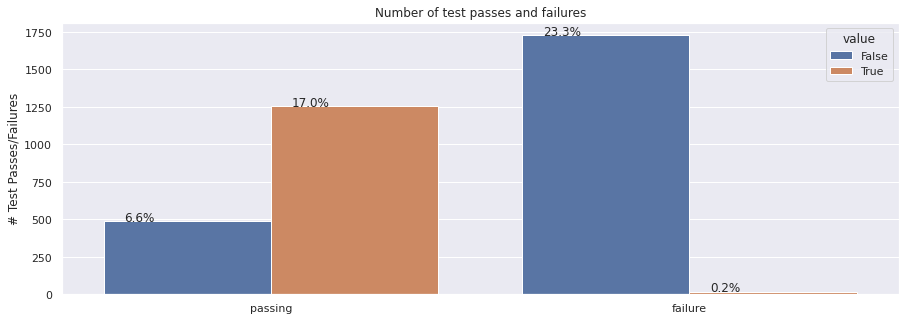

In [25]:
tpf_df_1 = tpf_df[["passing", "failure"]]
ax = sns.countplot(x="variable", hue="value", data=pd.melt(tpf_df_1))
plt.xlabel("")
plt.ylabel("# Test Passes/Failures")
plt.title("Number of test passes and failures")
with_hue(ax, pd.melt(tpf_df_1).variable, 2, 2)

From the above graph, we see that the total number of test passes that were successful was ~1250 and the number of tests that failed was about ~15. It is also important to note that if a test did not pass successfully, it does not neccessarily mean that it "failed", its possible that the test could be attributed to other status values such as those mentioned in https://github.com/aicoe-aiops/ocp-ci-analysis/blob/master/docs/cell_labels_in_testgrid.md.

### persistent_failures
The `persistent_failures` KPI measures the percent of failures that persist for long times.

In [26]:
selected_dashboard = '"redhat-assisted-installer"'
selected_job = "periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted"
selected_date = "2021-5-13"

In [27]:
pf_df = get_kpi_data(
    date=selected_date,
    dashboard=selected_dashboard,
    job=selected_job,
)

Neither "job" nor "grid" column found in metrics/avg_correlation/avg_correlation-2021-5-13.parquet. Maybe this df has a different schema. Appending it as-is, without filtering.
Neither "job" nor "grid" column found in metrics/correlation/correlation-2021-5-13.parquet. Maybe this df has a different schema. Appending it as-is, without filtering.


In [28]:
pf_df = pf_df.reset_index(drop=True)
pf_df.head()

timestamp  average_number_of_correlated_failures  \
0 2021-05-13 21:54:33.946221                            5206.174976   
1 2021-05-13 09:15:21.000000                                    NaN   
2 2021-05-10 00:01:21.000000                                    NaN   
3 2021-05-08 15:51:59.000000                                    NaN   
4 2021-05-07 05:28:18.000000                                    NaN   

                           tab  \
0                          NaN   
1  "redhat-assisted-installer"   
2  "redhat-assisted-installer"   
3  "redhat-assisted-installer"   
4  "redhat-assisted-installer"   

                                                grid     test test_blocked  \
0                                                NaN      NaN          NaN   
1  periodic-ci-openshift-release-master-nightly-4...  Overall        False   
2  periodic-ci-openshift-release-master-nightly-4...  Overall        False   
3  periodic-ci-openshift-release-master-nightly-4...  Overall        False   
4  periodic-ci-openshift-release-master-nightly-4...  Overall        False   

  test_timed_out  test_duration build_failure build_passing  ...  \
0            NaN            NaN           NaN           NaN  ...   
1          False            NaN           NaN           NaN  ...   
2          False            NaN           NaN           NaN  ...   
3          False            NaN           NaN           NaN  ...   
4          False            NaN           NaN           NaN  ...   

  correlated_tests flake pct_fixed consec_fail_rate  mean_fail_len  \
0              NaN   NaN       NaN              NaN            NaN   
1              NaN   NaN       NaN              NaN            NaN   
2              NaN   NaN       NaN              NaN            NaN   
3              NaN   NaN       NaN              NaN            NaN   
4              NaN   NaN       NaN              NaN            NaN   

   mean_time_to_fix  pass_to_fail_rate  fail_to_pass_rate  failure  passing  
0               NaN                NaN                NaN      NaN      NaN  
1               NaN                NaN                NaN      NaN      NaN  
2               NaN                NaN                NaN      NaN      NaN  
3               NaN                NaN                NaN      NaN      NaN  
4               NaN                NaN                NaN      NaN      NaN  

[5 rows x 22 columns]

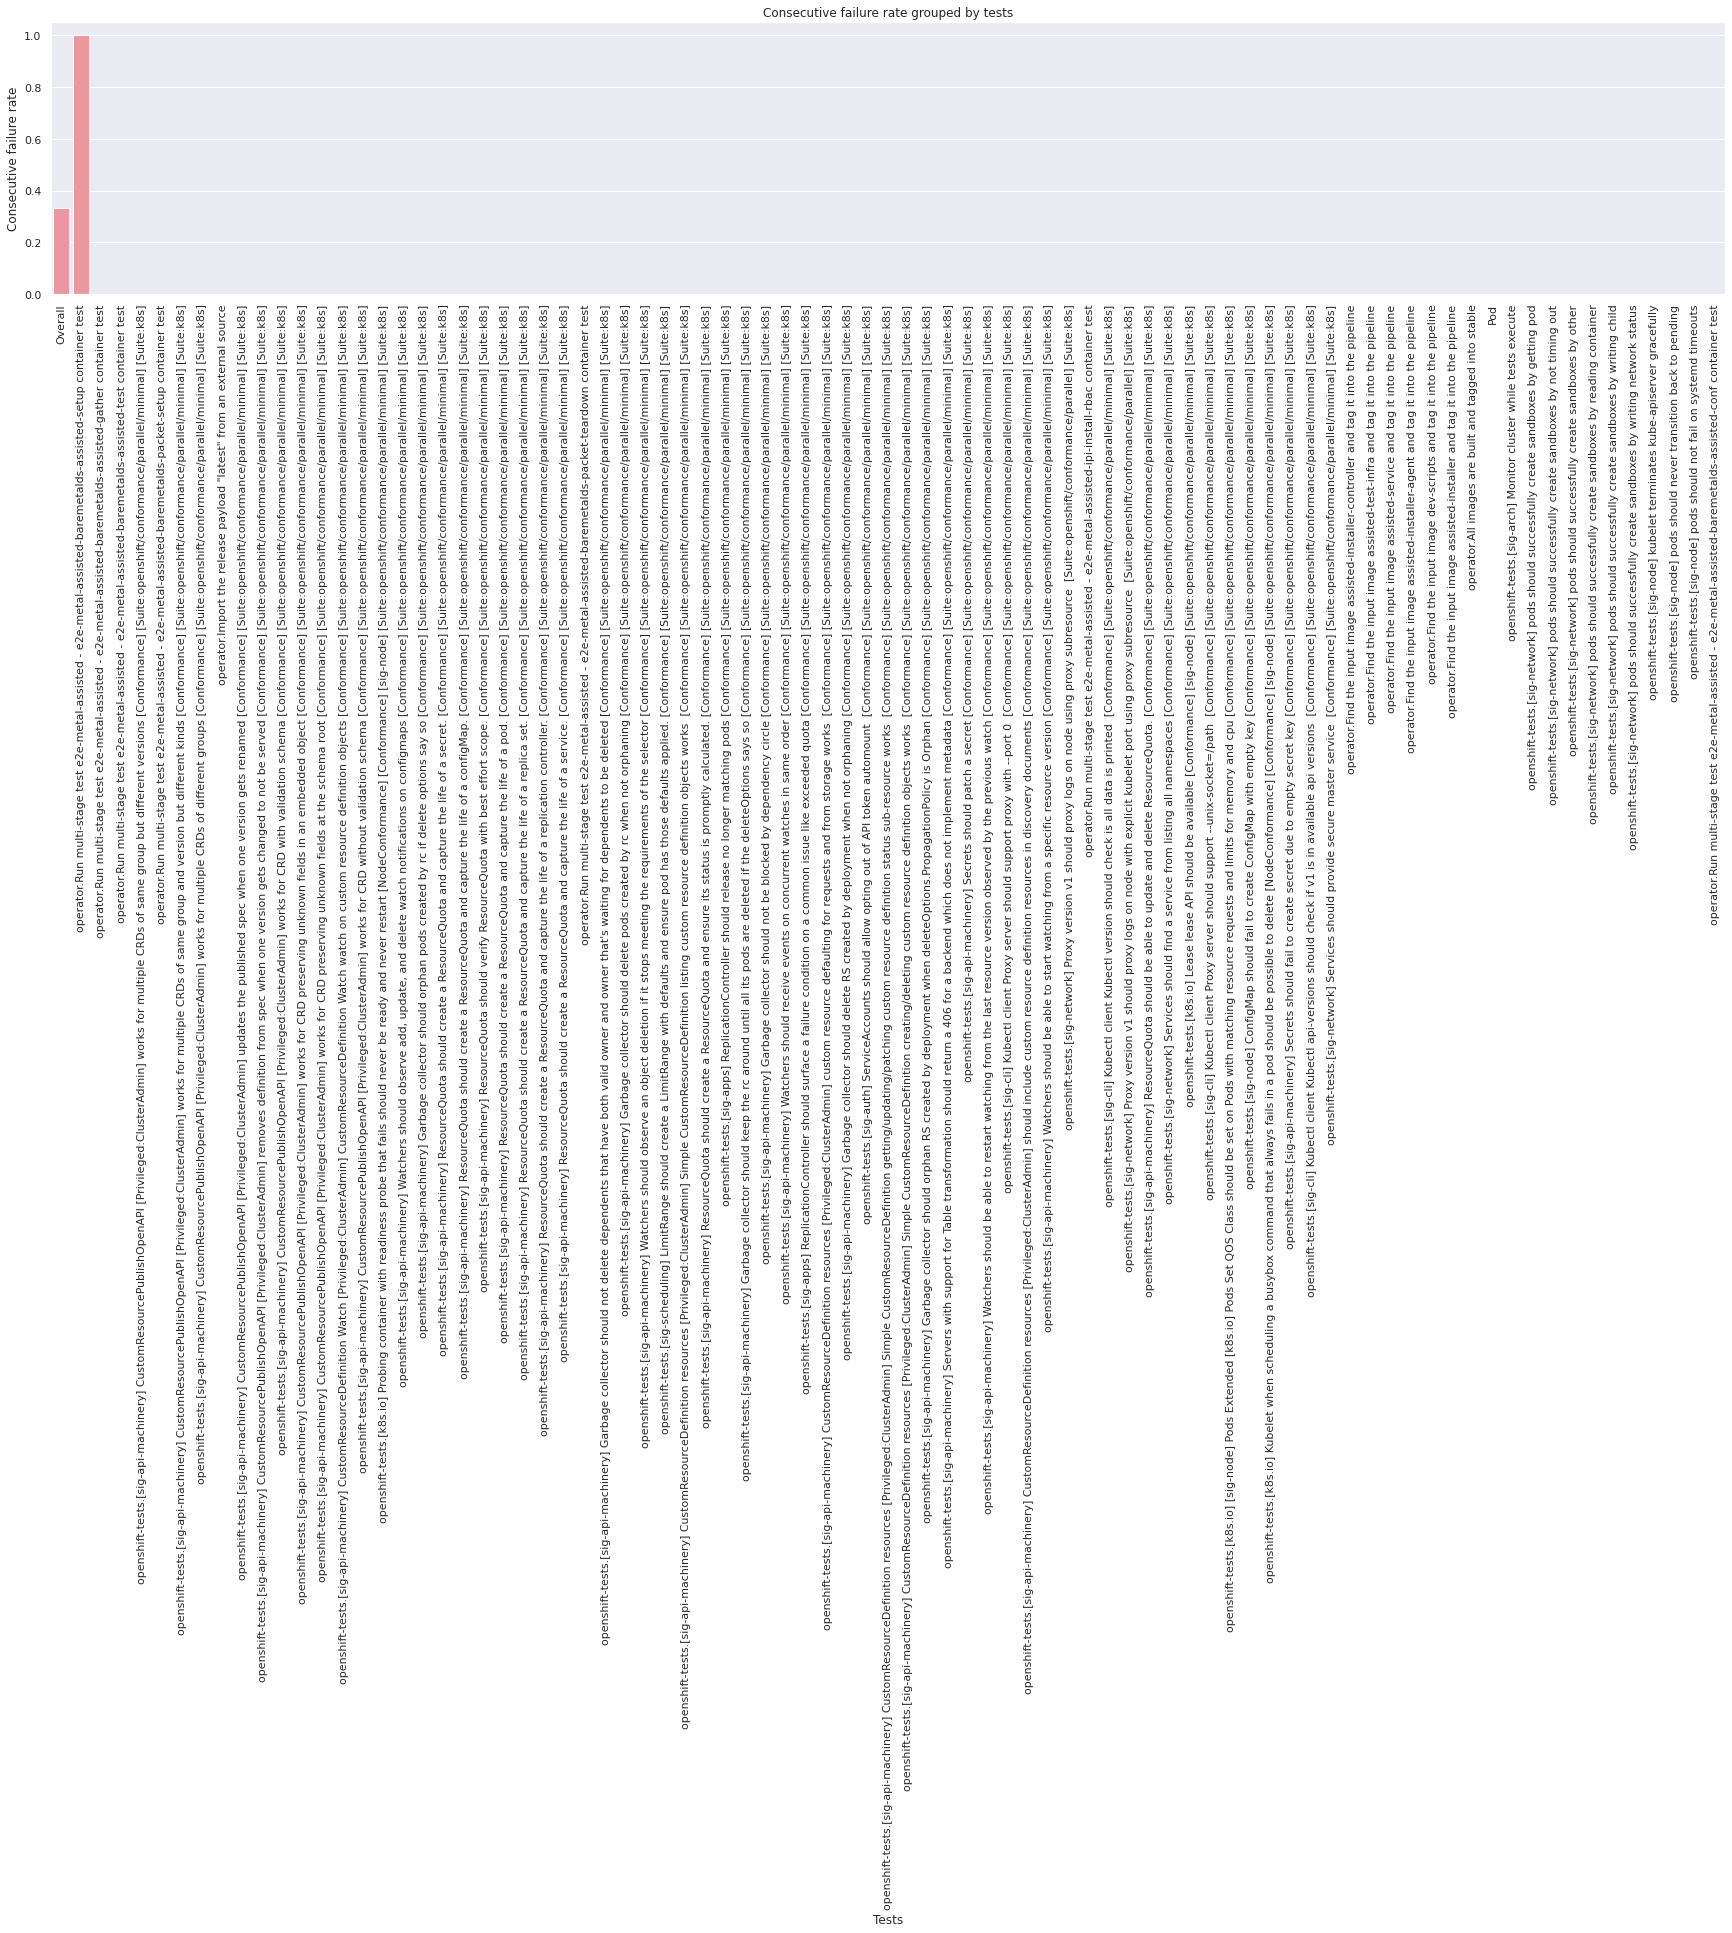

In [55]:
# Lets plot the consecutive failure rate for all tests
sns.set(rc={"figure.figsize": (30, 5)})
sns.barplot(x="test", y="consec_fail_rate", data=pf_df)
plt.xlabel("Tests")
plt.ylabel("Consecutive failure rate")
plt.title("Consecutive failure rate grouped by tests")
plt.xticks(rotation=90)
plt.show()

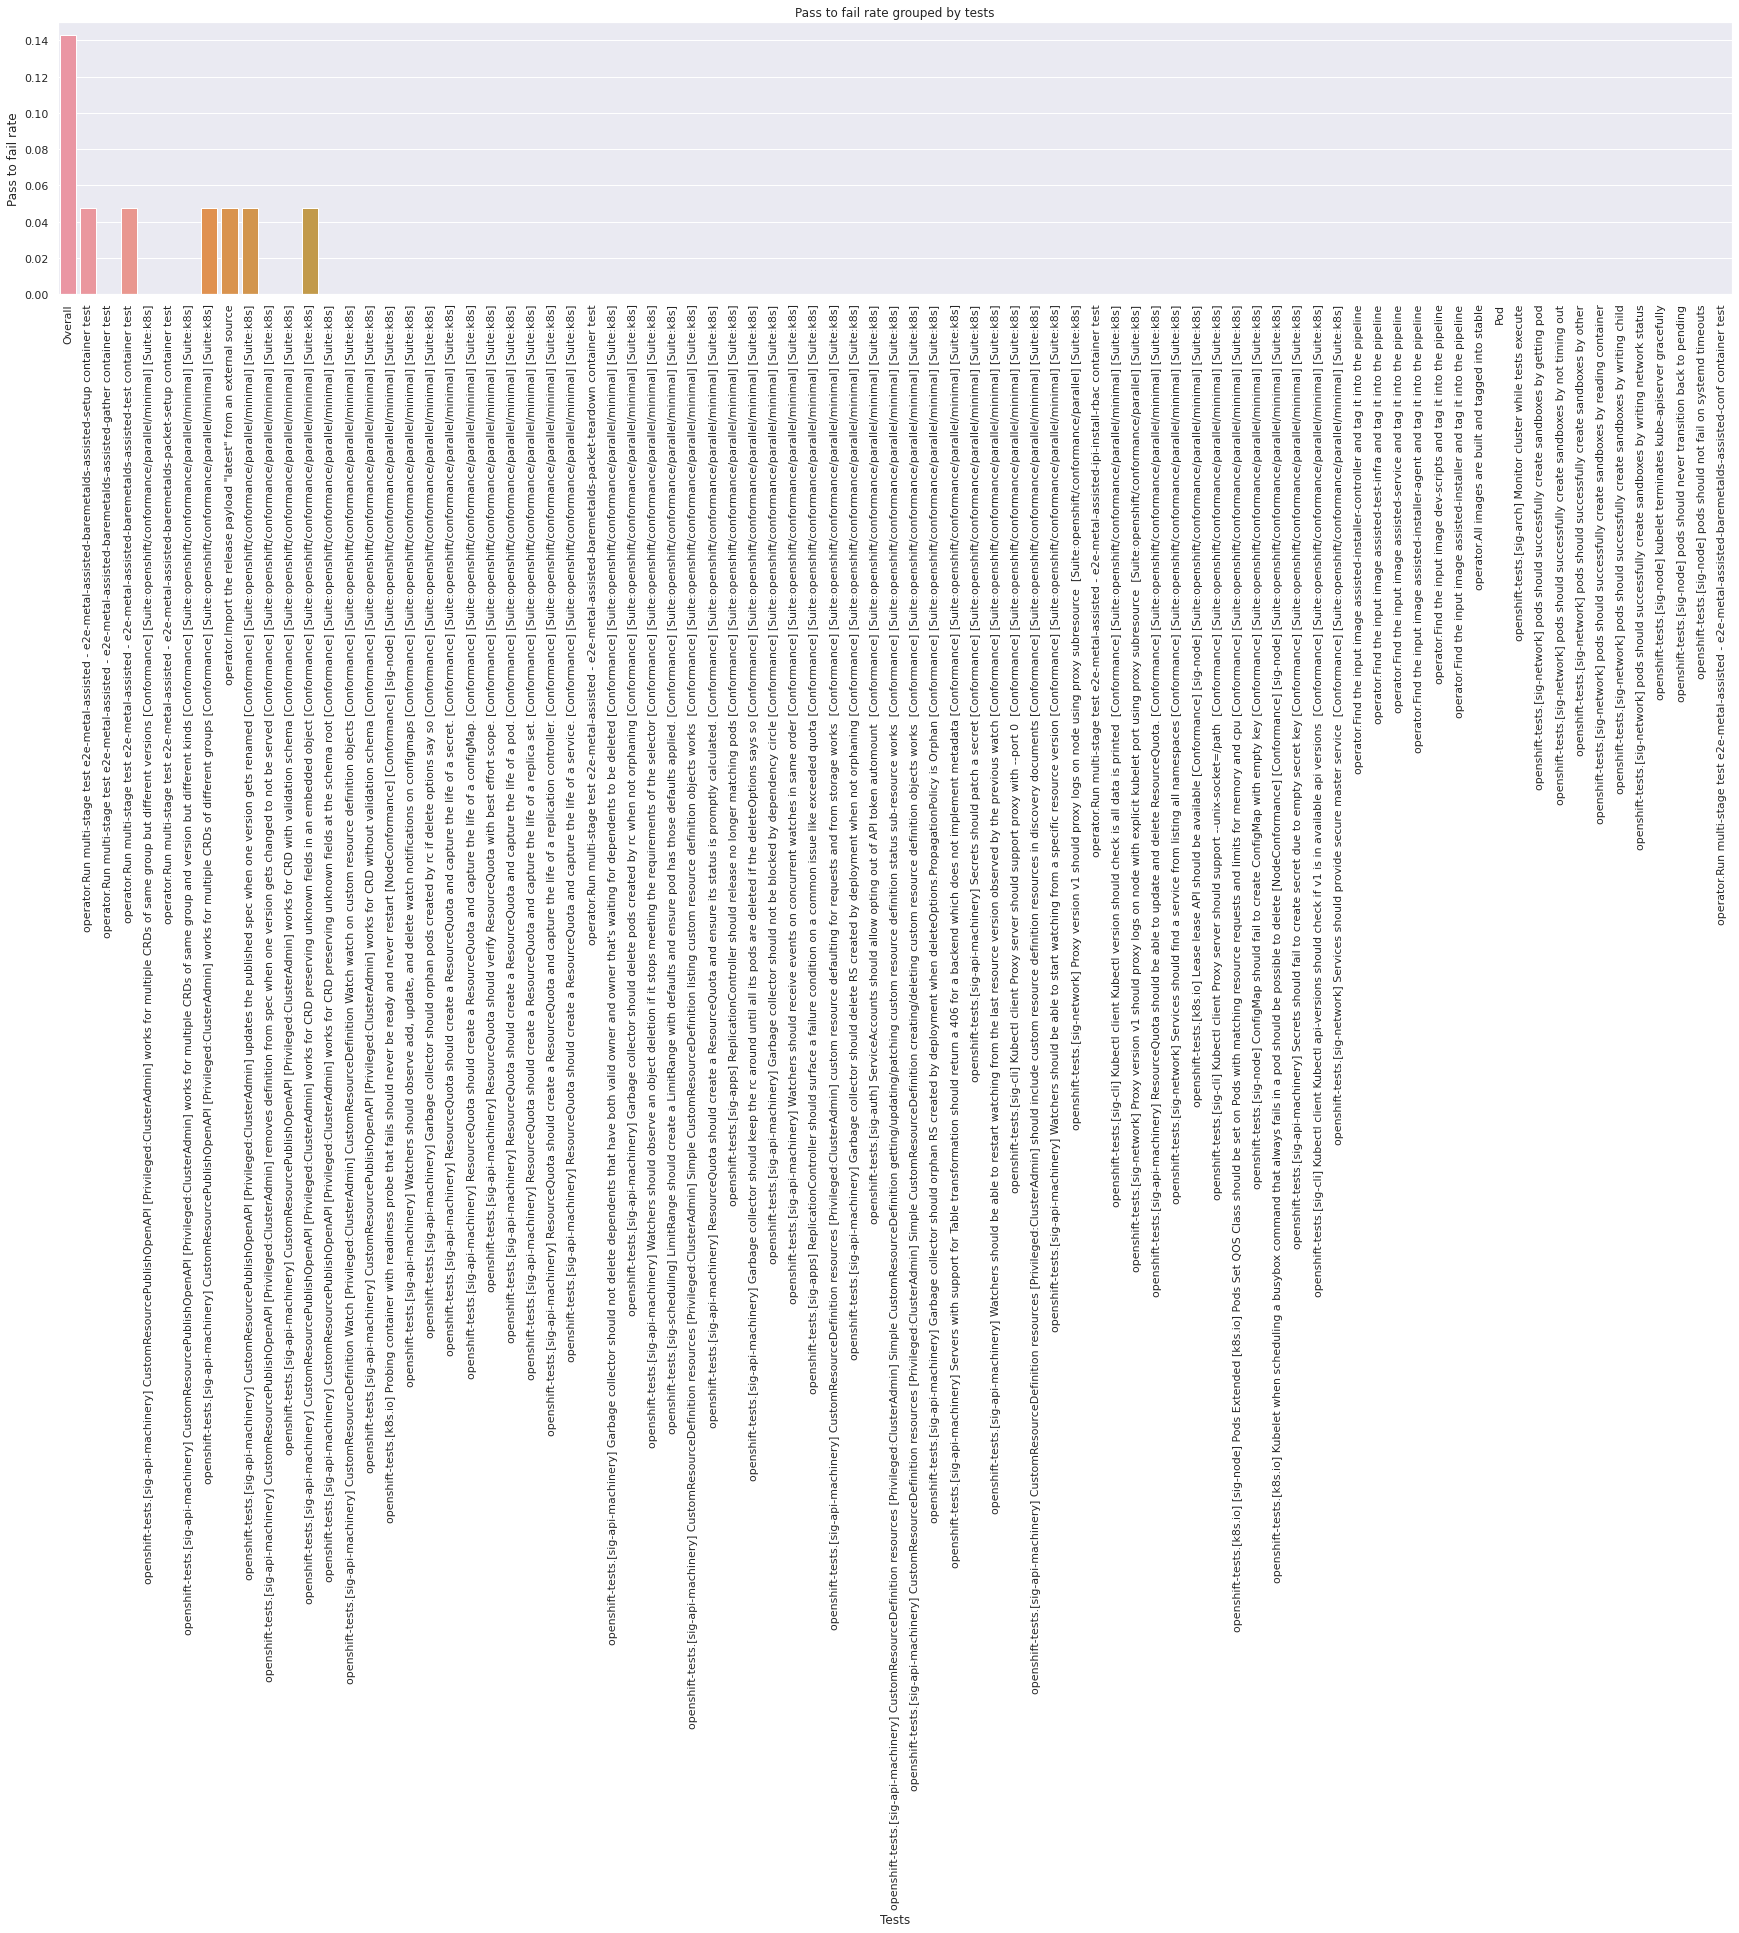

In [56]:
# Lets plot the rate of transition from test pass to fail
sns.set(rc={"figure.figsize": (30, 5)})
sns.barplot(x="test", y="pass_to_fail_rate", data=pf_df)
plt.xlabel("Tests")
plt.ylabel("Pass to fail rate")
plt.title("Pass to fail rate grouped by tests")
plt.xticks(rotation=90)
plt.show()

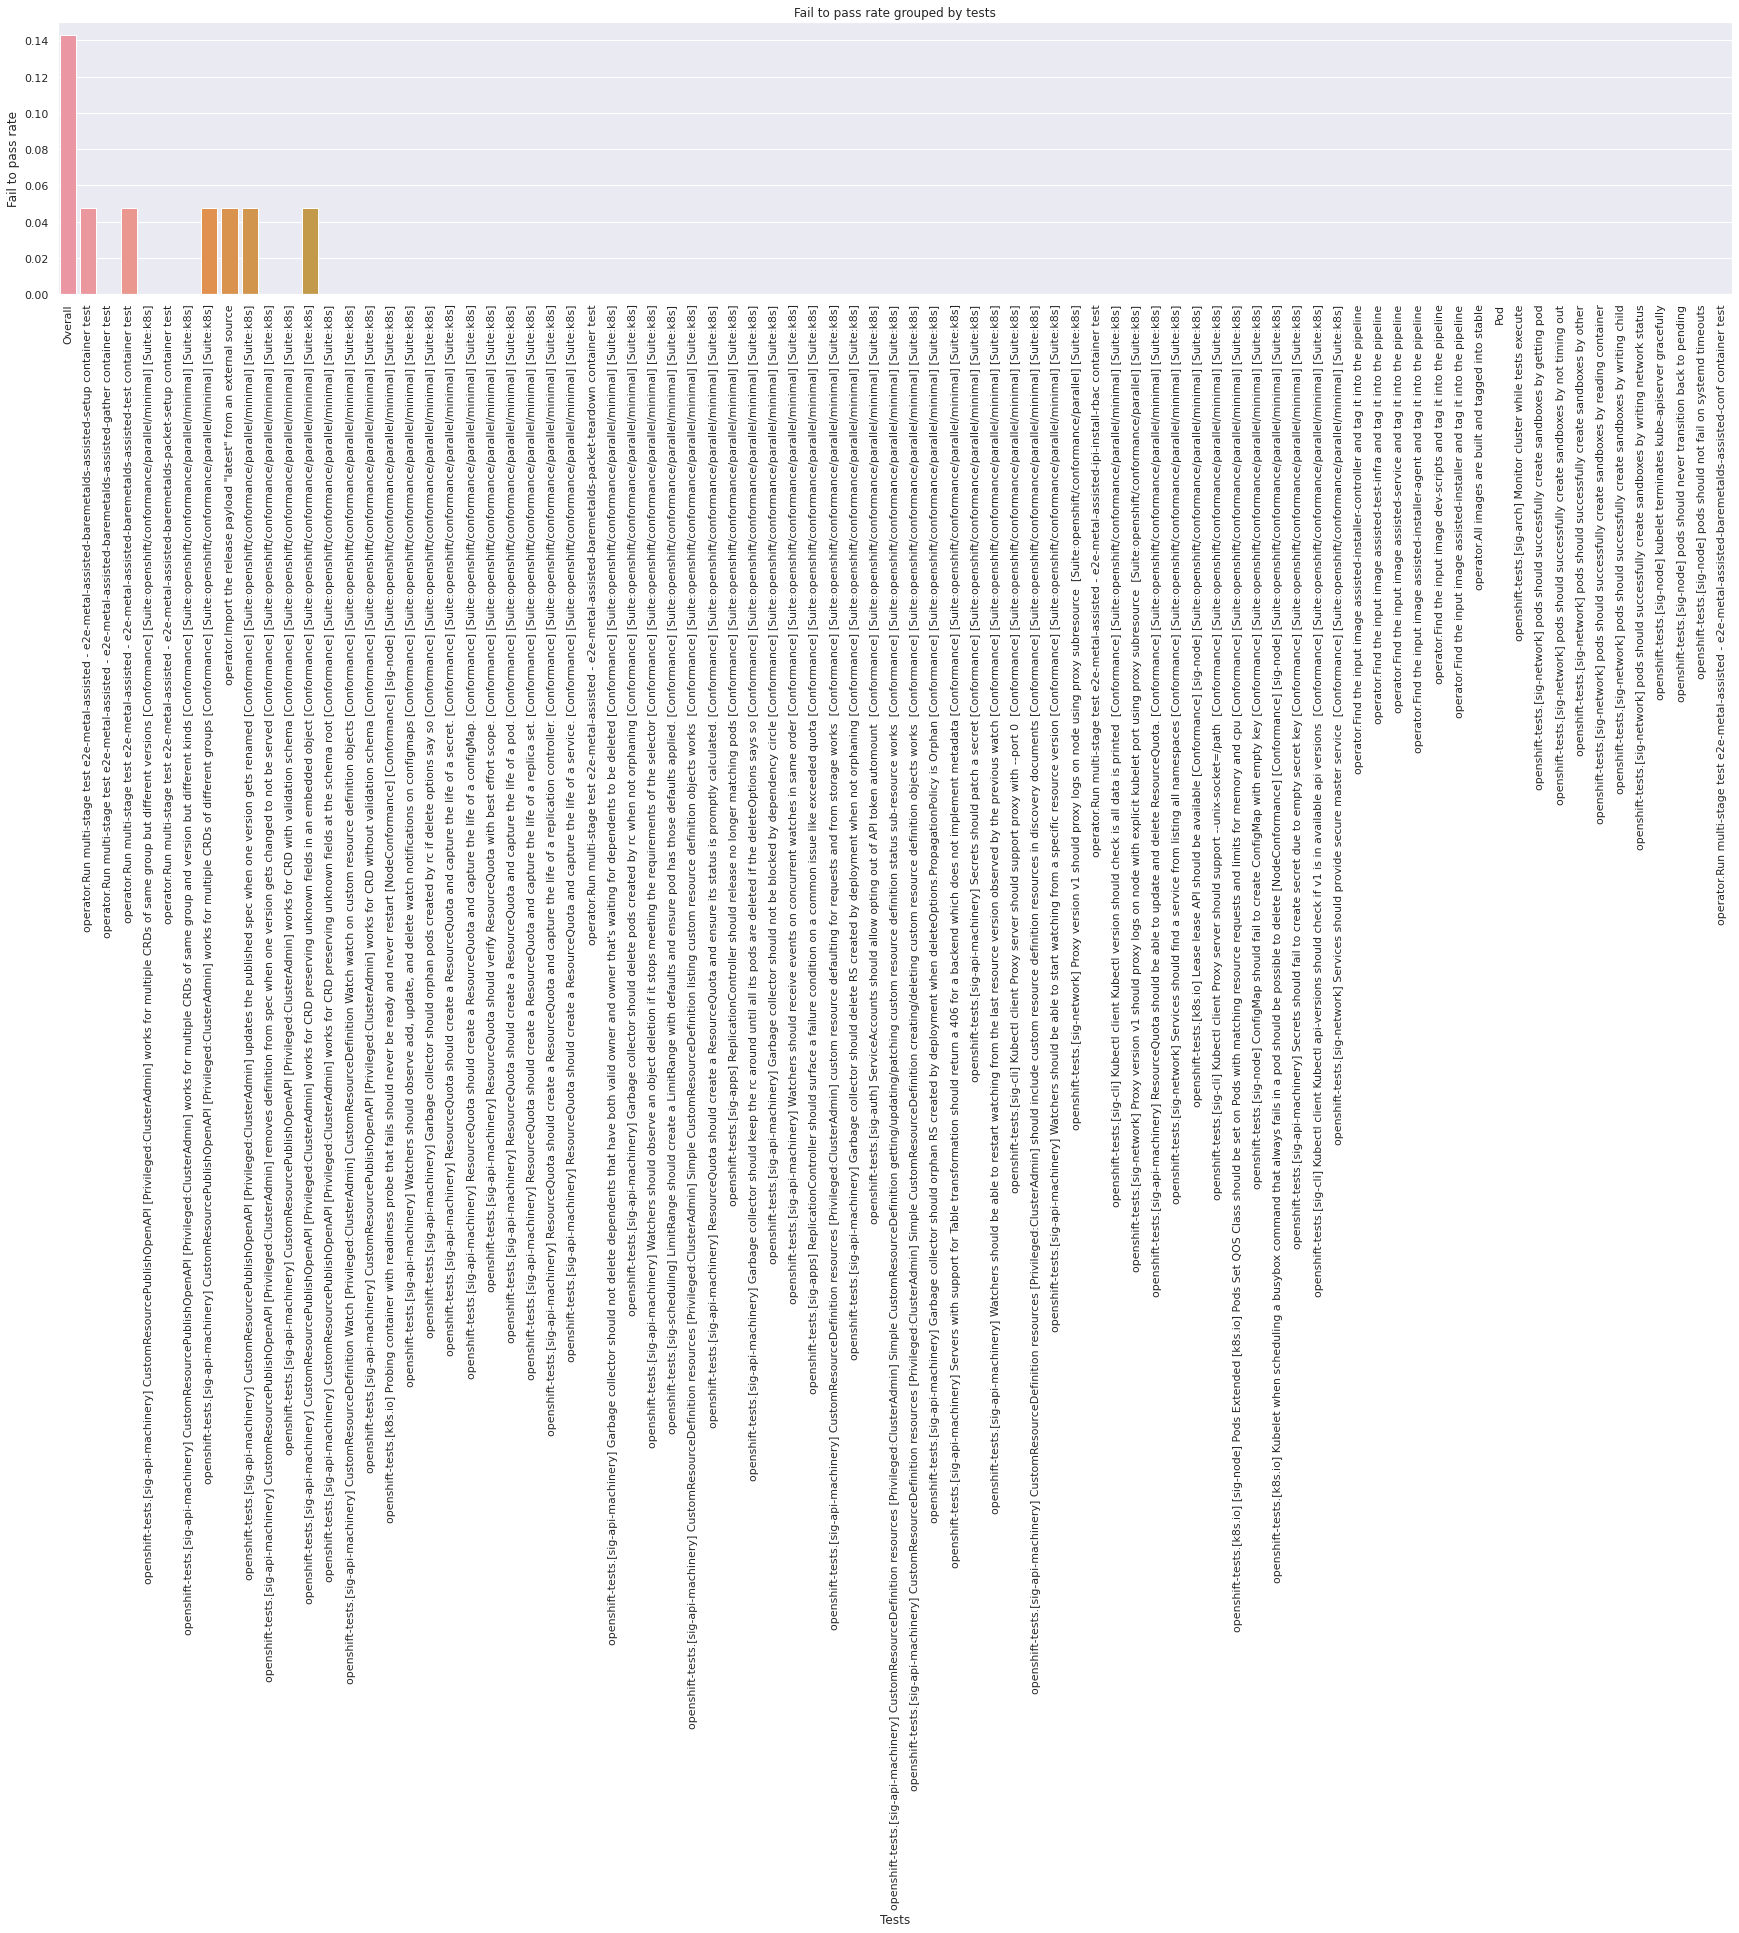

In [57]:
# Lets plot the rate of transition from test fail to pass
sns.set(rc={"figure.figsize": (30, 5)})
sns.barplot(x="test", y="fail_to_pass_rate", data=pf_df)
plt.xlabel("Tests")
plt.ylabel("Fail to pass rate")
plt.title("Fail to pass rate grouped by tests")
plt.xticks(rotation=90)
plt.show()

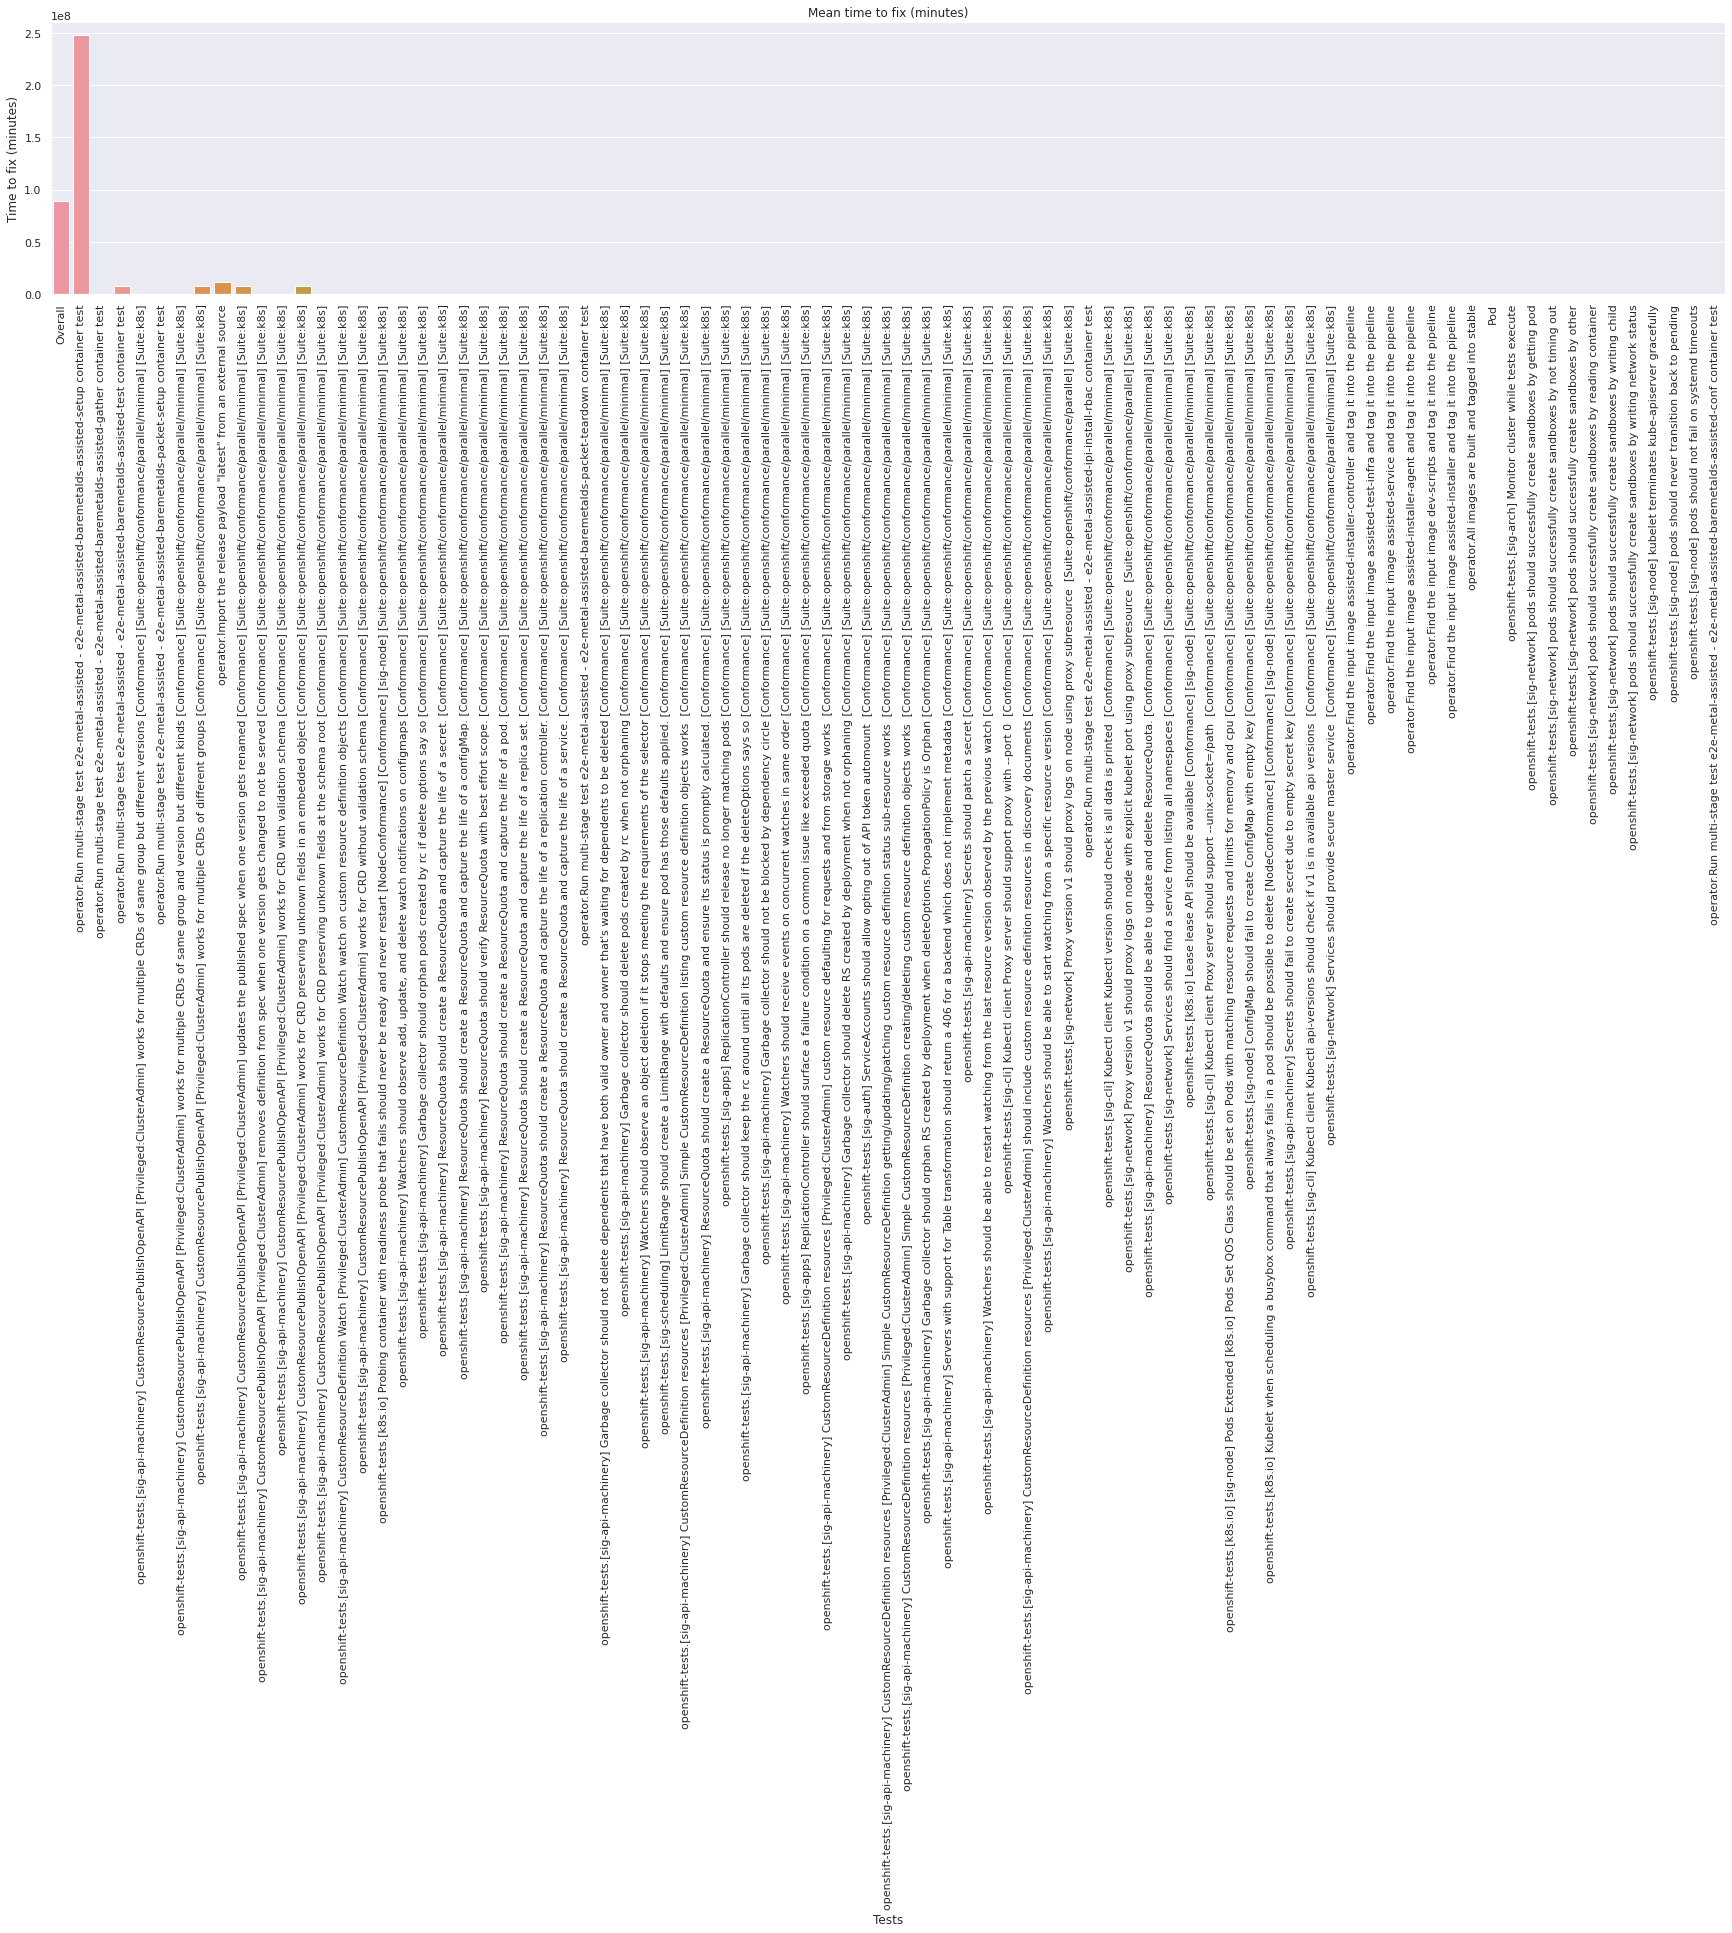

In [32]:
# Lets plot the mean time to fix for each of the tests
sns.set(rc={"figure.figsize": (30, 5)})
sns.barplot(x="test", y="mean_time_to_fix", data=pf_df)
plt.xlabel("Tests")
plt.ylabel("Time to fix (minutes)")
plt.title("Mean time to fix (minutes)")
plt.xticks(rotation=90)
plt.show()

### time_to_test
The `time_to_test` KPI measures the time taken to run builds over time. Lets plot this test duration over time.

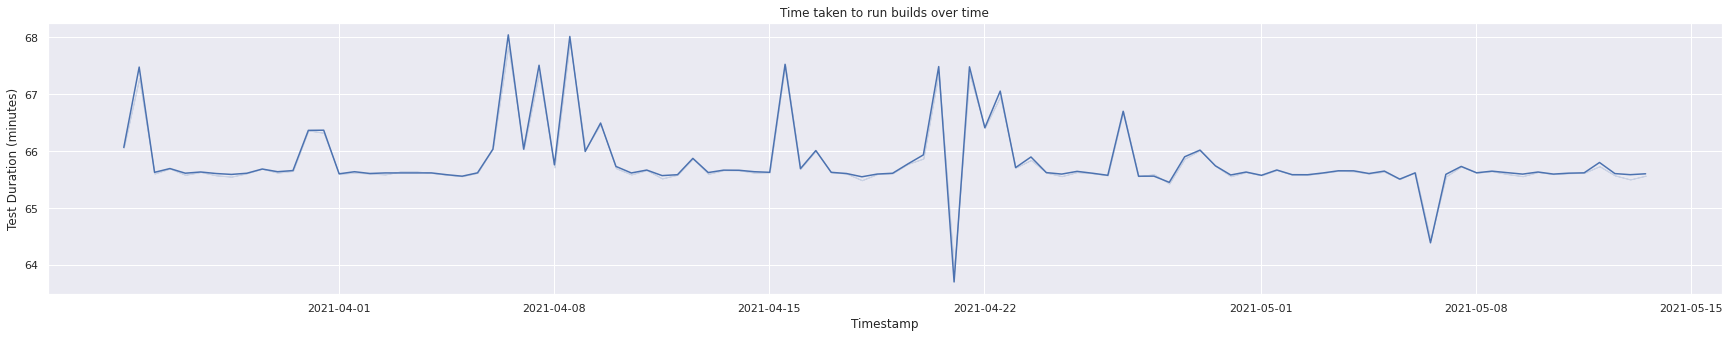

In [33]:
selected_kpis = "test_duration"

sns.lineplot(x="timestamp", y=selected_kpis, data=df, ci=0)
plt.xlabel("Timestamp")
plt.ylabel("Test Duration (minutes)")
plt.title("Time taken to run builds over time")
plt.show()

In the above graph, we see how the time taken to run a build changes over time and we notice when there are spikes or when irregular builds occur.

Now, let's try to see the test duration time for the various tests i.e. understand what the average test duration is and the tests falling within this test duration.

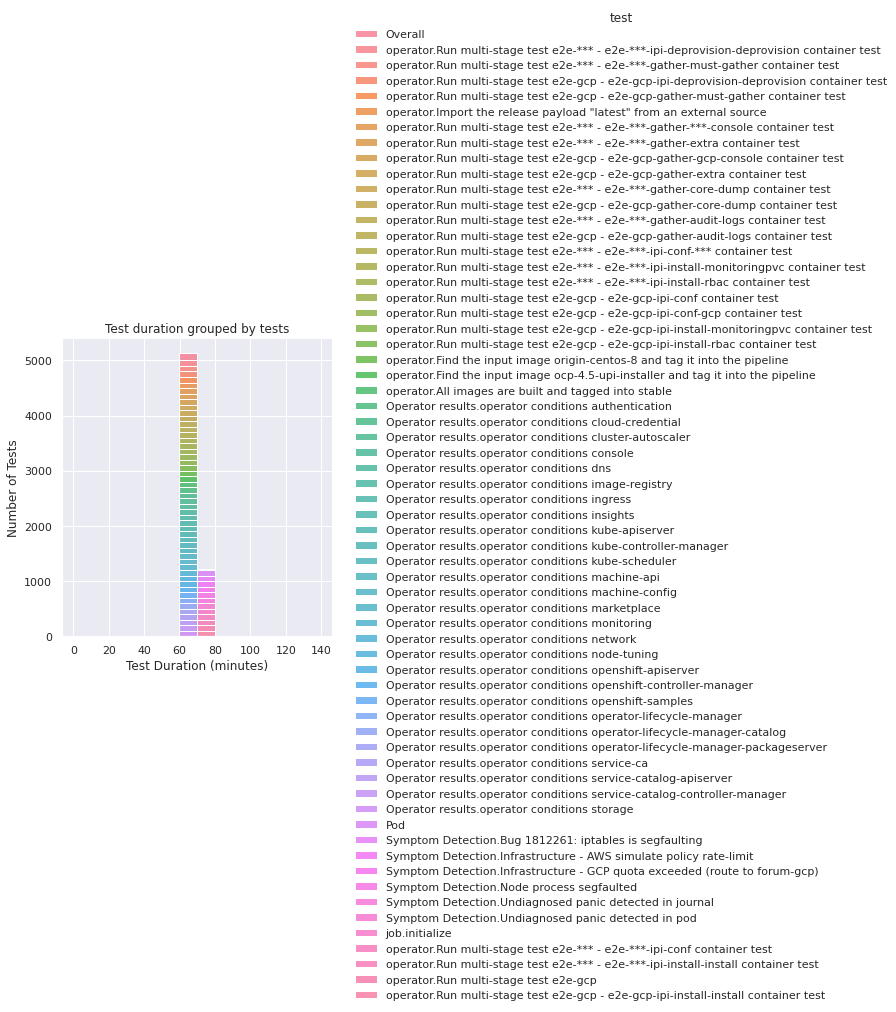

In [34]:
sns.displot(x="test_duration", data=df, hue="test", multiple="stack")
plt.xlabel("Test Duration (minutes)")
plt.ylabel("Number of Tests")
plt.title("Test duration grouped by tests")
plt.show()

From the above distribution plot, we see that for the dashboard "redhat-openshift-ocp-release-4.2-informing" and job "periodic-ci-openshift-release-master-ci-4.2-e2e-gcp", most of the tests took about ~65 minutes to run the build and there were a few tests like "Symptom Detection.Node process segfaulted" which took a little longer, about ~70-80 minutes to run.

### pct_fixed
The `pct_fixed` KPI measures the percent of tests that were failing and are now fixed. 

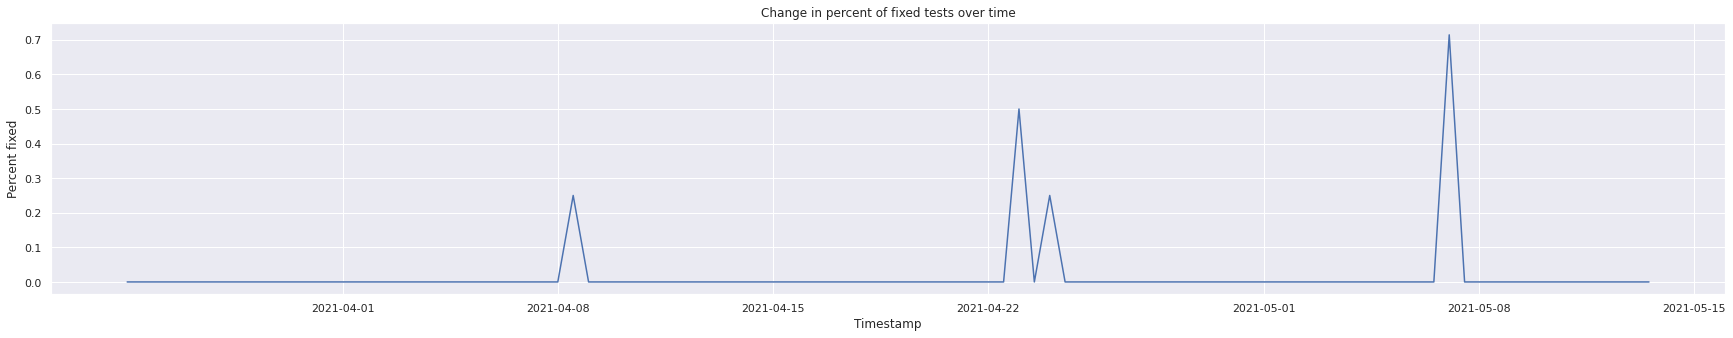

In [35]:
selected_kpis = "pct_fixed"

sns.lineplot(x="timestamp", y=selected_kpis, data=df)
plt.xlabel("Timestamp")
plt.ylabel("Percent fixed")
plt.title("Change in percent of fixed tests over time")
plt.show()

From the above line graph, we see that the percent of fixed tests are quite low. This means that only a small percent of previously failing tests get fixed in each new run, which in turn implies that their CI process is likely not as efficient as it could be.

### avg_correlation
The `avg_correlation` KPI measures the avergae number of failures for highly correlated tests i.e, sets of tests that most commonly fail together.

In [36]:
# load data, KPI avg_correlation

selected_filename = "avg_correlation"

metric_df_avg_corr = pd.DataFrame(
    columns=["timestamp", "average_number_of_correlated_failures"]
)

for d in dates_available_for_kpifile[selected_filename]:
    metric_df_avg_corr = metric_df_avg_corr.append(
        cc.read_from_ceph(
            s3_path,
            f"{selected_filename}/{selected_filename}-{d}.parquet",
        )
    )

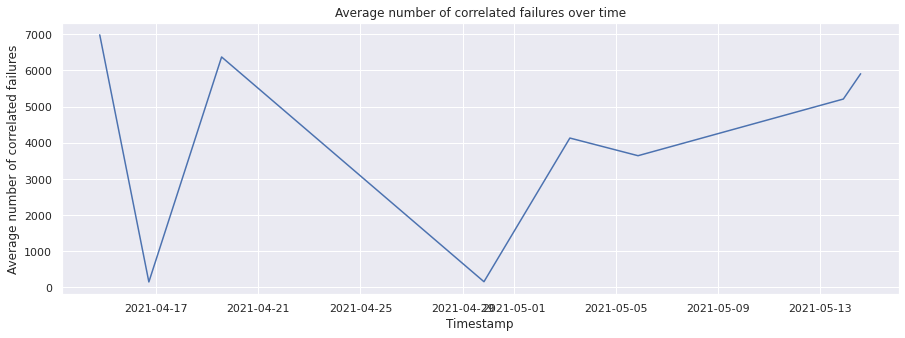

In [37]:
# graph data, KPI average number of correlated failures

metric_name = "average_number_of_correlated_failures"

sns.set(rc={"figure.figsize": (15, 5)})
sns.lineplot(x="timestamp", y=metric_name, data=metric_df_avg_corr)
plt.xlabel("Timestamp")
plt.ylabel("Average number of correlated failures")
plt.title("Average number of correlated failures over time")
plt.show()

From the above line graph, we see that the average number of correlated failures vary quite drastically over time, from being as high as 7000 and having no correlated failures at all.

### correlation
The `correlation` KPI measures the number of correlated failures per test.

In [38]:
# read data, KPI correlation
selected_filename = "correlation"
selected_date = "2021-5-13"

metric_df_corr = cc.read_from_ceph(
    s3_path,
    f"{selected_filename}/{selected_filename}-{selected_date}.parquet",
)
metric_df_corr["corr_count"] = metric_df_corr["correlated_tests"].str.len()

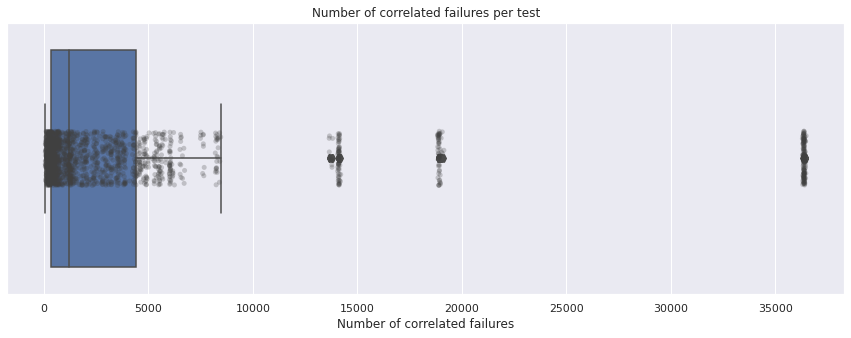

In [39]:
# graph data, KPI correlation
metric_name = "corr_count"

sns.set(rc={"figure.figsize": (15, 5)})
sns.boxplot(x=metric_name, data=metric_df_corr)
sns.stripplot(x=metric_name, data=metric_df_corr, color="0.25", alpha=0.25)
plt.xlabel("Number of correlated failures")
plt.title("Number of correlated failures per test")
plt.show()

From the above box plot, we see that the mean number of correlated failures is about ~6000 and the maximum number of correlated failures observed on that day was about ~20000.

## Visualize KPIs for the different Jobs under a given Dashboard

In this section, we'll compare jobs within a dashboard on the basis of the selected KPIs. That is, given a dashboard (e.g. `"redhat-openshift-ocp-release-4.6-informing"`), we will plot the KPI values corresponding to the `Overall` row for each job (e.g. `periodic-ci-openshift-release-master-ci-4.6-e2e-aws`, `periodic-ci-openshift-release-master-ci-4.6-e2e-gcp`, etc.) under that dashboard. This would help us determine if our efforts should be focused on a particular platform or install config for OpenShift.

In [40]:
selected_filename = "number_of_flakes"

In [41]:
print(f'Available dates to choose from for the file "{selected_filename}":', end="\n\n")
for d in dates_available_for_kpifile[selected_filename]:
    print(d)

Available dates to choose from for the file "number_of_flakes":

2021-4-14
2021-4-16
2021-4-19
2021-4-27
2021-4-29
2021-5-13
2021-5-14
2021-5-3
2021-5-4
2021-5-5
2021-5-6


In [42]:
selected_date = "2021-5-13"

In [43]:
print(f'Available KPIs to choose from for the file "{selected_filename}":', end="\n\n")
for m in kpis_in_kpifile[selected_filename]:
    print(m)

Available KPIs to choose from for the file "number_of_flakes":

test_duration
flake


In [44]:
selected_kpis = [
    "test_duration",
    "flake",
]

In [45]:
# read one of the kpis to plot the selected metrics objects from ceph
metric_df = cc.read_from_ceph(
    s3_path,
    f"{selected_filename}/{selected_filename}-{selected_date}.parquet",
)
metric_df.head()

timestamp                          tab  \
0 2021-05-13 09:15:21  "redhat-assisted-installer"   
1 2021-05-10 00:01:21  "redhat-assisted-installer"   
2 2021-05-08 15:51:59  "redhat-assisted-installer"   
3 2021-05-07 05:28:18  "redhat-assisted-installer"   
4 2021-05-07 02:32:03  "redhat-assisted-installer"   

                                                grid     test  test_duration  \
0  periodic-ci-openshift-release-master-nightly-4...  Overall      93.450000   
1  periodic-ci-openshift-release-master-nightly-4...  Overall      94.450000   
2  periodic-ci-openshift-release-master-nightly-4...  Overall      89.816667   
3  periodic-ci-openshift-release-master-nightly-4...  Overall     100.833333   
4  periodic-ci-openshift-release-master-nightly-4...  Overall     105.516667   

   flake  
0  False  
1  False  
2  False  
3  False  
4  False

In [46]:
tabs = metric_df["tab"].unique()
print("Available dashboard tabs to choose from:", end="\n\n")
for t in tabs:
    print(t)

Available dashboard tabs to choose from:

"redhat-assisted-installer"
"redhat-openshift-informing"
"redhat-openshift-ocp-release-4.1-blocking"
"redhat-openshift-ocp-release-4.1-informing"
"redhat-openshift-ocp-release-4.2-blocking"
"redhat-openshift-ocp-release-4.2-informing"
"redhat-openshift-ocp-release-4.3-blocking"
"redhat-openshift-ocp-release-4.3-broken"
"redhat-openshift-ocp-release-4.3-informing"
"redhat-openshift-ocp-release-4.4-blocking"
"redhat-openshift-ocp-release-4.4-broken"
"redhat-openshift-ocp-release-4.4-informing"
"redhat-openshift-ocp-release-4.5-blocking"
"redhat-openshift-ocp-release-4.5-broken"
"redhat-openshift-ocp-release-4.5-informing"
"redhat-openshift-ocp-release-4.6-blocking"
"redhat-openshift-ocp-release-4.6-broken"
"redhat-openshift-ocp-release-4.6-informing"
"redhat-openshift-ocp-release-4.7-blocking"
"redhat-openshift-ocp-release-4.7-broken"
"redhat-openshift-ocp-release-4.7-informing"
"redhat-openshift-ocp-release-4.8-blocking"
"redhat-openshift-ocp-re

In [47]:
# Select the dashboard and test
selected_tab = '"redhat-assisted-installer"'
selected_test = "Overall"

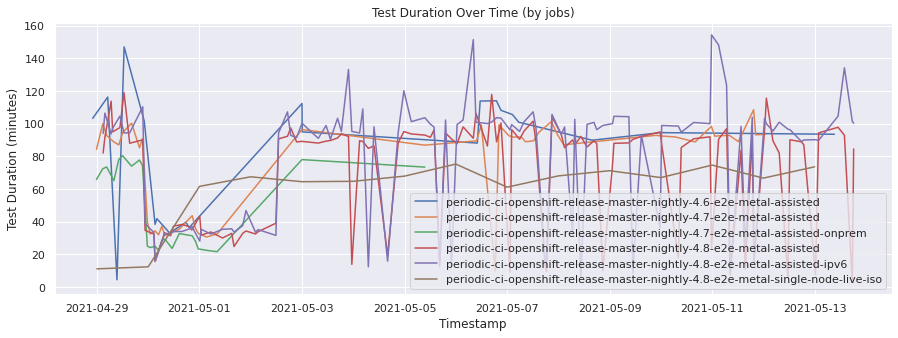

In [48]:
# Here we are plotting the test duration metric over time for the different jobs within a given dashboard tab
plot_grids(
    selected_tab,
    selected_test,
    metric_df,
    selected_kpis[0],
    "Timestamp",
    "Test Duration (minutes)",
    "Test Duration Over Time (by jobs)",
)

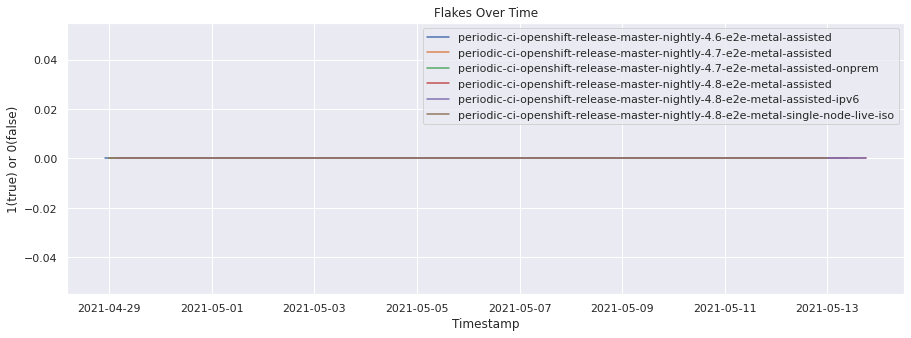

In [49]:
# Here we are plotting the flakes over time for the different jobs within a given dashboard tab
plot_grids(
    selected_tab,
    selected_test,
    metric_df,
    selected_kpis[1],
    "Timestamp",
    "1(true) or 0(false)",
    "Flakes Over Time",
)

## Visualize the KPIs for different Tests under a given Job

In this section, we'll compare the various tests that are run in a job, on the basis of the selected KPIs. That is, given a job (e.g. `periodic-ci-openshift-release-master-ci-4.6-e2e-gcp`), we will plot the KPI values corresponding to each test (e.g. `operator conditions cluster-autoscaler`, `operator conditions cloud-credential`, etc.) under that job. This would help us determine if our efforts should be focused on a particular set of components in OpenShift.

In [50]:
# For a given dashboard, identify all the jobs (grids)
selected_tab = '"redhat-openshift-ocp-release-4.1-informing"'

grids = metric_df[metric_df["tab"] == selected_tab]["grid"].unique()
print("Available grids to choose from:", end="\n\n")
for g in grids:
    print(g)

Available grids to choose from:

release-openshift-origin-installer-e2e-aws-upgrade-4.1-stable-to-4.1-nightly
release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1


In [51]:
# Select the job(grid)
selected_grid = "release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1"

In [52]:
df = metric_df.copy()
df = df[(df["tab"] == selected_tab) & (df["grid"] == selected_grid)]
df.head()

timestamp                                           tab  \
2921996 2021-05-13 01:04:58  "redhat-openshift-ocp-release-4.1-informing"   
2921997 2021-05-12 01:04:18  "redhat-openshift-ocp-release-4.1-informing"   
2921998 2021-05-11 01:03:55  "redhat-openshift-ocp-release-4.1-informing"   
2921999 2021-05-10 01:03:16  "redhat-openshift-ocp-release-4.1-informing"   
2922000 2021-05-09 01:03:01  "redhat-openshift-ocp-release-4.1-informing"   

                                                      grid     test  \
2921996  release-openshift-origin-installer-e2e-aws-upg...  Overall   
2921997  release-openshift-origin-installer-e2e-aws-upg...  Overall   
2921998  release-openshift-origin-installer-e2e-aws-upg...  Overall   
2921999  release-openshift-origin-installer-e2e-aws-upg...  Overall   
2922000  release-openshift-origin-installer-e2e-aws-upg...  Overall   

         test_duration  flake  
2921996      74.866667  False  
2921997       8.516667  False  
2921998     121.250000  False  
2921999      61.083333  False  
2922000      60.633333  False

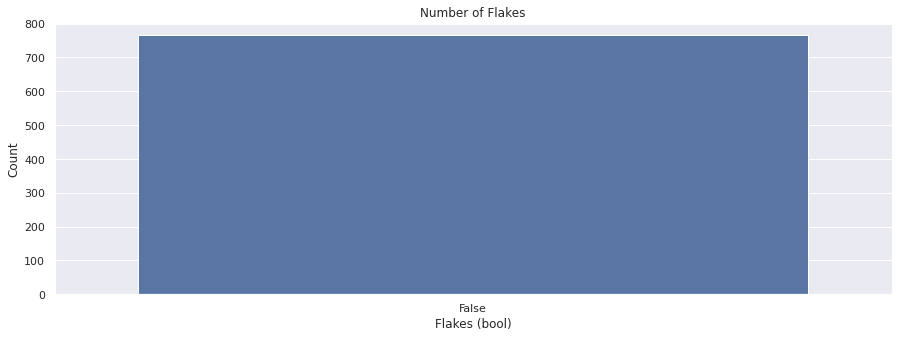

In [53]:
## Count of flakes identified in the tests for a particular grid(job) in a given TestGrid dashboard tab
sns.countplot(x="flake", data=df)
plt.xlabel("Flakes (bool)")
plt.ylabel("Count")
plt.title("Number of Flakes")
plt.show()

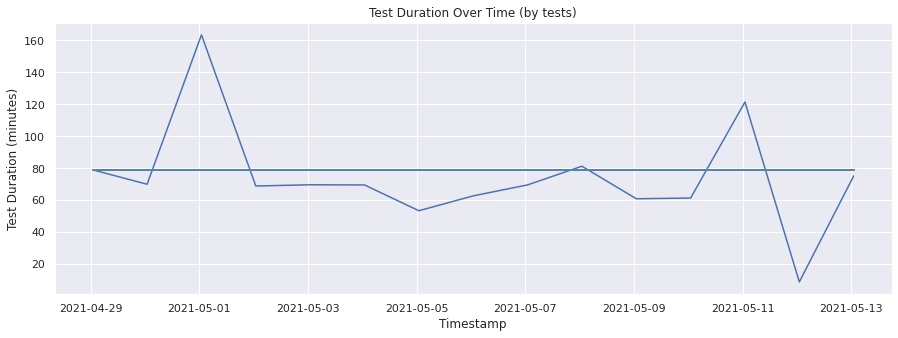

In [54]:
# Here we are plotting the test duration metric over time for different tests within a given dashboard tab
plot_tests(
    selected_tab,
    selected_grid,
    metric_df,
    selected_kpis[0],
    "Timestamp",
    "Test Duration (minutes)",
    "Test Duration Over Time (by tests)",
)

**NOTE** The values for "test_duration" are only available for "Overall" hence the above graph shows only one lineplot.

## Conclusion :
In this notebook, we have tried to read the collected metrics from ceph and use visualization libraries like `seaborn` to explore our data. We have tried two different granularities here :

* Dashboard, Job pair: Here we visualize all the available KPIs for a selected dashboard, job pair.
* Job level : Here we choose a dashboard and analyze across various jobs for "Overall" test.
* Test level : Here we choose a dashboard and job and then visualize the metrics for various tests.

For future work, we could look into other collected metrics and explore more visualization tools for further detailed analyses. 